In [1]:
import pandapower as pp
import pandapower.networks as pn
from pandapower.plotting import simple_plot

import pandas as pd
import numpy as np
import cvxpy as cp
import networkx as nx
import custom_networks
from solution_files_manager import SolutionFilesManager

In [2]:
import os
folder = os.path.abspath(os.getcwd())

## Create network

In [3]:
case = "case30"
case_type = 0
is_custom = False
net = custom_networks.get_case(case, case_type, is_custom)

In [4]:
net.trafo

,name,std_type,hv_bus,lv_bus,sn_mva,vn_hv_kv,vn_lv_kv,vk_percent,vkr_percent,pfe_kw,...,tap_neutral,tap_min,tap_max,tap_step_percent,tap_step_degree,tap_pos,tap_phase_shifter,parallel,df,in_service


In [5]:
# net.trafo["tap_step_percent"] = np.nan
# net.trafo["tap_side"] = None
# net.trafo["tap_pos"] = np.nan
# net.trafo["tap_neutral"] = 0

In [6]:
# net.trafo.at[0, "tap_step_percent"] = 2.0
# net.trafo.at[1, "tap_step_percent"] = 2.0
# net.trafo.at[10, "tap_step_percent"] = 2.0

In [7]:
net.trafo["tap_step_percent"] = 10.0
net.trafo.loc[net.trafo["tap_side"].isna(), ["tap_step_percent"]] = np.nan

# net.trafo["vk_percent"] = 0
# net.trafo["sn_mva"] = 0
# net.trafo["max_loading_percent"] = 0  # no effect

In [8]:
# # deprecated
# net.bus["zone"] = None
# net.load = net.load.drop(["controllable"], axis=1)
# net.load["type"] = "wye"
# net.line.drop(["max_loading_percent"], axis=1)
# net.line["type"] = None
# net.f_hz = 50

# net.line["max_i_ka"] = np.zeros(len(net.line))
# net.line["c_nf_per_km"] = np.zeros(len(net.line))

In [9]:
# # convert all values to p.u.; no longer used

# # parameters
# net.load["p_mw"] = net.load["p_mw"] / net.sn_mva
# net.load["q_mvar"] = net.load["q_mvar"] / net.sn_mva

# net.line["r_ohm_per_km"] = np.array((net.line['r_ohm_per_km'] * net.line["length_km"] * net.sn_mva / net.line['parallel'])) / ((net.bus.loc[net.line.from_bus.values, "vn_kv"].values) ** 2)
# net.line["x_ohm_per_km"] = np.array((net.line['x_ohm_per_km'] * net.line["length_km"] * net.sn_mva / net.line['parallel'])) / ((net.bus.loc[net.line.from_bus.values, "vn_kv"].values) ** 2)

# # bounds
# for col_name in ["max_p_mw", "min_p_mw", "max_q_mvar", "min_q_mvar"]:
#     net.gen[col_name] = net.gen[col_name] / net.sn_mva
#     net.ext_grid[col_name] = net.ext_grid[col_name] / net.sn_mva


# net.bus["vn_kv"] = 1
# net.sn_mva = 1

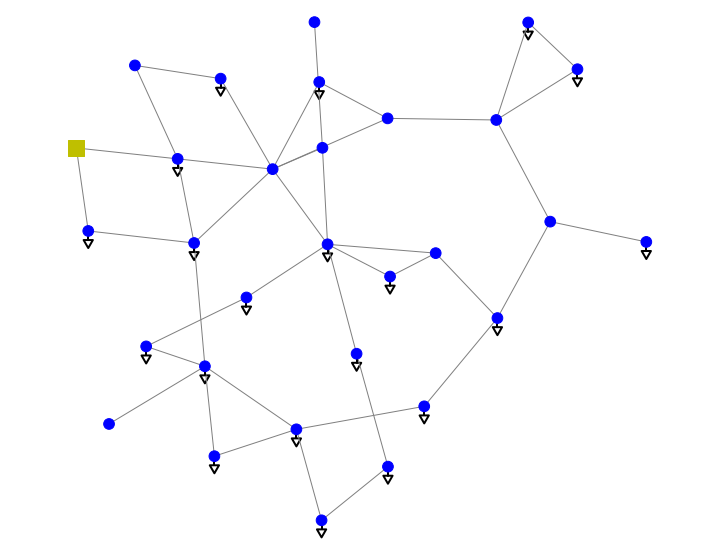

<AxesSubplot:>

In [10]:
simple_plot(net, plot_loads=True, plot_sgens=True)

## Solve

In [11]:
pp.runopp(net, verbose=False, suppress_warnings=True)

In [12]:
net.res_cost

578.4862507022578

### Save solution

In [13]:
sfm = SolutionFilesManager(folder, case, case_type, "orig")

In [14]:
V_polar = net.res_bus[["vm_pu", "va_degree"]].to_numpy()
V = V_polar[:,[0]] * np.exp(1j * (V_polar[:,[1]] / 180 * np.pi))
V

array([[1.        +0.j        ],
       [1.00392232-0.01465027j],
       [0.99834139-0.03904578j],
       [0.99845202-0.04631623j],
       [0.99463289-0.04118497j],
       [0.99381031-0.05125713j],
       [0.98436095-0.05593185j],
       [0.98222994-0.05757971j],
       [1.01047327-0.06758687j],
       [1.0192015 -0.07614055j],
       [1.01047327-0.06758687j],
       [1.0413256 -0.07931507j],
       [1.09718245-0.06323468j],
       [1.02831767-0.08700124j],
       [1.02975412-0.08188491j],
       [1.02461325-0.0824751j ],
       [1.01541892-0.08126026j],
       [1.01267677-0.09146916j],
       [1.00626201-0.09408358j],
       [1.00856049-0.09050283j],
       [1.02777362-0.07678992j],
       [1.03430762-0.07511367j],
       [1.04130346-0.06121404j],
       [1.03131461-0.05969834j],
       [1.04986619-0.01674515j],
       [1.03277267-0.02366391j],
       [1.06884716+0.01490741j],
       [1.0018666 -0.04816113j],
       [1.0499813 -0.00615062j],
       [1.03891104-0.02047634j]])

In [15]:
p_g = np.concatenate((net.res_ext_grid[["p_mw"]].to_numpy(), net.res_gen[["p_mw"]].to_numpy(), net.res_sgen[["p_mw"]].to_numpy())) \
    / net.sn_mva
q_g = np.concatenate((net.res_ext_grid[["q_mvar"]].to_numpy(), net.res_gen[["q_mvar"]].to_numpy(), net.res_sgen[["q_mvar"]].to_numpy())) \
    / net.sn_mva

In [16]:
p_g

array([[0.39448512],
       [0.531028  ],
       [0.22382039],
       [0.46459464],
       [0.15473338],
       [0.15125194]])

In [17]:
# sfm.save_solution(net.res_cost, V, p_g, q_g)